# Comparison of MLX and py-metal-compute to solve viscoelastic wave equation (VWE) using FDTD method

---

## Description
This notebook implements a stripped down version of the Viscoelastic Wave Equation (VWE) Finite-Difference Time-Difference (FDTD) calculation found in the [BabelViscoFDTD library](https://github.com/ProteusMRIgHIFU/BabelViscoFDTD). Using both [MLX](https://github.com/ml-explore/mlx) and a [fork of py-metal-compute](https://github.com/ProteusMRIgHIFU/py-metal-compute). Original project is at (py-metal-compute)[https://github.com/baldand/py-metal-compute]. MLX is a high-level library to run functions aimed for ML/AI using Apple Sillicon GPUs. py-metal-compute is aimed mainly for a close-to-hardware interface to run user-defined GPU kernels.

The implementation of the VWE has 3 main kernel functions (stress, particle, and sensors) that are called hundreds of times in a loop as results are updated in small temporal $\delta t$ steps.

## Problem
MLX does not replicate the current metalcompute implementation and the kernel seems to be returning early. BabelViscoFDTD is quite complex and is difficult to isolate only the VWE part of the code. However, We did our best to move the less relevant aspects of the code to the viscoelastic_utils.py file and kept the more important pieces inside a VWE class including kernel setup and execution. To simplify troubleshooting, only the stress kernel is enabled.

During our testing, we implemented the following call in our stress_kernel.c file as an easy check to see how the kernel was behaving. Note EL is a macro to access the Sigma_xy part of one of the output buffers using the i and j indices and is the result that is ultimately plotted at the end.

`EL(Sigma_xy,i,j) += 1; // TEST STATEMENT`

What we noticed is that after a certain point in the kernel, the results are no longer appearing as expected with results defaulting to the mlx init_value and no error being thrown.

## Pre-requisites
Use provided environment.yml file to create conda environment with all dependancies.

MLX version used for testing = 0.22.0

## Imports

In [1]:

%matplotlib inline

# Base
from math import ceil
import os
from pathlib import Path
import pickle
import platform
import re
import sys
import time

# Installed
from matplotlib import pyplot as plt
import metalcomputebabel as mc
import mlx.core as mx
import numpy as np
from scipy.optimize import fmin_slsqp
from scipy.interpolate import interp1d
from skimage.metrics import mean_squared_error, normalized_root_mse

# Local
import viscoelastic_utils as vwe_utils

## Parameters

In [2]:
# Device Specific
gpu_device = 'M1'               # GPU device name

# Simulation
dt = 1.5e-7                     # time step
medium_SOS = 1500               # m/s - water
medium_density = 1000           # kg/m3
pml_thickness = 12              # grid points for perfect matching layer
points_per_wavelength = 9       # minimum step of 6 is recommended
reflection_limit = 1.0000e-05   # reflection parameter for PML
tx_diameter = 0.03              # m - circular piston
tx_plane_loc = 0.01             # m - in XY plane at Z = 0.01 m
us_amplitude = 100e3            # Pa
us_frequency = 350e3            # Hz
x_dim = 0.05                    # m
y_dim = 0.10                    # m

## Simulation Domain Setup

In [3]:
# Domain Properties
shortest_wavelength = medium_SOS/us_frequency
spatial_step = shortest_wavelength/ points_per_wavelength

# Domain Dimensions
domain_dims =  np.array([x_dim,y_dim])  # in m, x,y,z
N1 = int(np.ceil(domain_dims[0]/spatial_step)+2*pml_thickness)
N2 = int(np.ceil(domain_dims[1]/spatial_step)+2*pml_thickness)
print('Domain size',N1,N2)

# Time Dimensions
sim_time=np.sqrt(domain_dims[0]**2+domain_dims[1]**2)/medium_SOS #time to cross one corner to another
sensor_steps=int((1/us_frequency/8)/dt) # for the sensors, we do not need so much high temporal resolution, so we are keeping 8 time points per perioid

# Material Map
material_map=np.zeros((N1,N2),np.uint32) # note the 32 bit size
material_list=np.zeros((1,5)) # one material in this examples
material_list[0,0]=medium_density # water density
material_list[0,1]=medium_SOS # water SoS
# all other parameters are set to 0 

# Constants
StaggeredConstants={}
StaggeredConstants['ColDensity']=0
StaggeredConstants['ColLongSOS']=1
StaggeredConstants['ColShearSOS']=2
StaggeredConstants['ColLongAtt']=3
StaggeredConstants['ColShearAtt']=4


Domain size 129 234


## Generate Source Map + Source Time Signal

Number of time points in source signal: 78


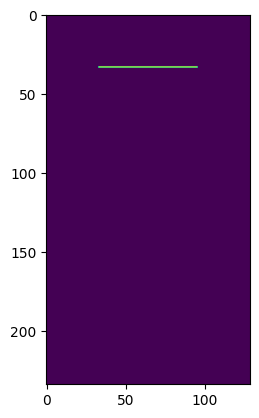

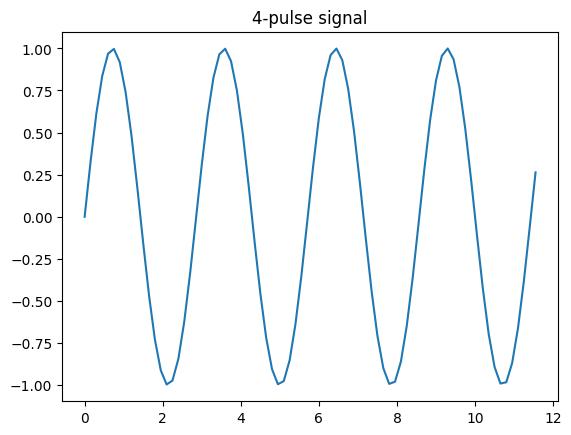

In [4]:
# Generate line source
def MakeLineSource(DimX,SpatialStep,Diameter):
    # simple defintion of a circular source centred in the domain
    XDim=np.arange(DimX)*SpatialStep
    XDim-=XDim.mean()
    MaskSource=np.abs(XDim)<=(Diameter/2.0)
    return (MaskSource*1.0).astype(np.uint32)

line_source=MakeLineSource(N1,spatial_step,tx_diameter)
source_map=np.zeros((N1,N2),np.uint32)
z_loc=int(np.round(tx_plane_loc/spatial_step))+pml_thickness
source_map[:,z_loc] = line_source 

# Plot source map
plt.figure()
plt.imshow(source_map.T)


amp_displacement = us_amplitude/medium_density/medium_SOS # We use a 100 kPa source, we just need to convert to particle displacement
Ox=np.zeros((N1,N2))
Oy=np.zeros((N1,N2))
Oy[source_map>0]=1 #only Y has a value of 1

# Generate source time signal
source_length = 4.0/us_frequency # we will use 4 pulses
source_time_vector=np.arange(0,source_length+dt,dt)

# Plot source time signal
pulse_source = np.sin(2*np.pi*us_frequency*source_time_vector)
plt.figure()
plt.plot(source_time_vector*1e6,pulse_source)
plt.title('4-pulse signal')

# note we need expressively to arrange the data in a 2D array
pulse_source=np.reshape(pulse_source,(1,len(source_time_vector))) 
print("Number of time points in source signal:",len(source_time_vector))

## Generate Sensor Map

Text(0.5, 1.0, 'Sensor map location')

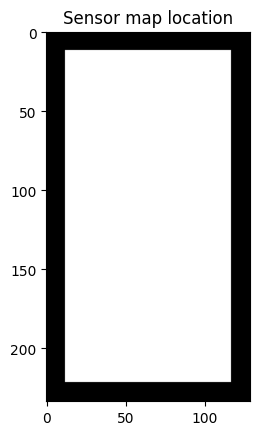

In [5]:
# Define sensor map
sensor_map=np.zeros((N1,N2),np.uint32)
sensor_map[pml_thickness:-pml_thickness,pml_thickness:-pml_thickness]=1

# Plot sensor map
plt.figure()
plt.imshow(sensor_map.T,cmap=plt.cm.gray)
plt.title('Sensor map location')

## Visco-elastic Wave Equation Kernel Codes

In [6]:
base_header = ""
stress_kernel = ""
particle_kernel = ""
sensors_kernel = ""

with open('base_header.h','r') as f:
    base_header = f.read()
    
with open('stress_kernel.c','r') as f:
    stress_kernel = f.read()
    
with open('particle_kernel.c','r') as f:
    particle_kernel = f.read()
    
with open('sensors_kernel.c','r') as f:
    sensors_kernel = f.read()

## VWE class
Handles GPU initialization, kernel setup, and kernel execution

In [7]:
class VWE:
    def __init__(self):
        MASKID={}
        MASKID['Vx']=           0x0000000001
        MASKID['Vy']  =         0x0000000002
        MASKID['Sigmaxx']  =    0x0000000004
        MASKID['Sigmayy'] =     0x0000000008
        MASKID['Sigmaxy'] =     0x0000000010
        MASKID['Pressure'] =    0x0000000020
        MASKID['Pressure_gx'] = 0x0000000040
        MASKID['Pressure_gy'] = 0x0000000080
        MASKID['SEL_RMS'] =0x0000000001
        MASKID['SEL_PEAK']=0x0000000002
        
        self.MASKID=MASKID
    
    def kernel_setup(self,arguments,using_mlx=False):
        """ Setup kernel code by adding constant params to header and and
        allocating memory for kernel inputs and outputs """
        
        # Keep track of setup time
        t0=time.time()
        
        # Class variables
        self.using_mlx = using_mlx
        self.FUNCTION_LOCALS = {}
        for i in ['MAIN_1' ]:
            self.FUNCTION_LOCALS[i] = {'STRESS':[0, 0, 0], 'PARTICLE':[0, 0, 0]}
        self.FUNCTION_GLOBALS = {}
        for i in ['MAIN_1']:
            self.FUNCTION_GLOBALS[i] = {'STRESS':[0, 0, 0], 'PARTICLE':[0, 0, 0]}
        self.LENGTH_CONST_UINT = 2
        self.ConstantBufferUINT = np.zeros(self.LENGTH_CONST_UINT,np.uint32) # Zero array to hold uint args passed to kernel
        extra_params = {"BACKEND":"METAL"}
        
        global NumberSelRMSPeakMaps
        global NumberSelSensorMaps
        global TotalAllocs
        
        # Simulation dimensions
        N1=arguments['N1']
        N2=arguments['N2']
        
        # Definition of some constants, etc
        self.MAX_SIZE_PML = 101
        self._c_mex_type = np.zeros(12, np.uint64) # 12 mex_type arguments will be passed to kernels, this holds argument dimensions. mex_type is legacy naming from MATLAB version, essentially means float_type or double_type 
        self._c_uint_type = np.uint64(0) # Holds total dimensions for uint arguments
        self.HOST_INDEX_MEX = np.zeros((31, 2), np.uint64) # array used for allocating memory for mex_type arrays on host side. First column is index, second column is size
        self.HOST_INDEX_UINT = np.zeros((3, 2), np.uint64) # array used for allocating memory for uint arguments on host side. First column is index, second column is size
        self.LENGTH_INDEX_MEX = self.HOST_INDEX_MEX.shape[0] # number of mex_type kernel arguments
        self.LENGTH_INDEX_UINT = self.HOST_INDEX_UINT.shape[0] # number of uint kernel arguments
        self.ZoneCount = arguments['SPP_ZONES'] # Super Position Plane (SPP) Zones
        self._IndexDataMetal = { # Some arrays are combined into a single buffer argument, this tells use which argument position the array belongs to
            "V_x_x":0, "V_y_x":0, "V_x_y":0, "V_y_y":0,
            "Vx":1, "Vy":1,
            "Rxx":2, "Ryy":2,
            "Rxy":3,
            "Sigma_x_xx":4, "Sigma_y_xx":4, "Sigma_x_yy":4, "Sigma_y_yy":4,
            "Sigma_x_xy":5, "Sigma_y_xy":5,
            "Sigma_xy":6, "Sigma_xx":6,
            "Sigma_yy":7, "Pressure":7,
            "SourceFunctions":8,
            "LambdaMiuMatOverH":9, "LambdaMatOverH":9, "MiuMatOverH":9,
            "TauLong":9, "OneOverTauSigma":9, "TauShear":9, "InvRhoMatH":9, "Ox":9, "Oy":9,  
            "SqrAcc":10,
            "SensorOutput":11
            }
        self.C_IND = { # this tells us position in host index array?
            # uint_buffer
            "IndexSensorMap":0, "SourceMap":1, "MaterialMap": 2,
            # constant_buffer_uint
            "nStep":0, "TypeSource":1,
            # mex_buffer
            "V_x_x":0, "V_y_x":1, "V_x_y":2, "V_y_y":3, "Vx":4, "Vy":5,
            "Rxx":6, "Ryy":7, "Rxy":8,
            "Sigma_x_xx":9, "Sigma_y_xx":10, "Sigma_x_yy":11, "Sigma_y_yy":12,
            "Sigma_x_xy":13, "Sigma_y_xy":14, "Sigma_xy":15, 
            "Sigma_xx":16, "Sigma_yy":17, 
            "SourceFunctions":18, "LambdaMiuMatOverH":19, 
            "LambdaMatOverH":20, "MiuMatOverH":21, 
            "TauLong":22, "OneOverTauSigma":23, "TauShear":24, 
            "InvRhoMatH":25, "Ox":26, "Oy":27,
            "Pressure":28, "SqrAcc":29, "SensorOutput":30, 
            }
        
        # Validate inputs
        if (type(arguments)!=dict):
            raise TypeError( "The input parameter must be a dictionary")
        
        # Convert each array argument to a fortran organized array and non array arguments to standard numpy array containing argument value
        for key in arguments.keys():
            if type(arguments[key])==np.ndarray:
                if np.isfortran(arguments[key])==False:
                    #print "StaggeredFDTD_3D: Converting ndarray " + key + " to Fortran convention";
                    arguments[key] = np.asfortranarray(arguments[key])
            elif type(arguments[key])!=str:
                arguments[key]=np.array((arguments[key]))
        
        # Determine dtype to be used for kernel arguments
        if arguments['DT'].dtype==np.dtype('float32'):
            dtype=np.float32
        elif extra_params["BACKEND"] == "METAL":
            raise SystemError("Metal backend only supports single precision")
        else:
            dtype=np.float64

        # Set dtype for time step
        td = 'float'
        if dtype is np.float64:
            td='double'
        extra_params['td'] = td
        
        # Variables to keep track of number of output maps
        NumberSelRMSPeakMaps=0
        NumberSelSensorMaps=0
        TotalAllocs=0
        
        # Prepare the kernel code parameters
        outparams = self._prep_params_for_kernel(arguments)
        
        # Initialize GPU
        if using_mlx:
            self._init_MLX(gpu_device_name=arguments['DefaultGPUDeviceName'])
        else:
            self._init_MC(gpu_device_name=arguments['DefaultGPUDeviceName'])
            
        # Start assembling entire kernel code
        SCode = []
        if using_mlx: # Needed for proper MLX kernel compilation
            SCode.append("//----- MLX HEADER START -----//\n")
        
        SCode.append("#ifndef mexType\n#define mexType " + extra_params['td'] +"\n#endif\n")
        if using_mlx:
            SCode.append("#define METAL\n")
            SCode.append("#define MLX\n")
            # pass
        else:
            SCode.append("#define METAL\n")
            SCode.append("#define METALCOMPUTE\n")
        SCode.append("#ifndef MAX_SIZE_PML\n#define MAX_SIZE_PML 101\n#endif\n")
        
        if using_mlx: # Needed for proper MLX kernel compilation
            SCode.append("//----- MLX HEADER END -----//\n")
        
        # Add base header to entire kernel code
        SCode.append(base_header)
        
        # Create lists containing all possible outparams names split by data type
        LParamFloat = ['DT']
        LParamInt=["N1","N2", "Limit_I_low_PML", "Limit_J_low_PML", "Limit_I_up_PML","Limit_J_up_PML",\
                 "SizeCorrI","SizeCorrJ","PML_Thickness","NumberSources", "LengthSource","ZoneCount",\
                "SizePMLxp1","SizePMLyp1","SizePML","SizePMLxp1yp1","NumberSensors","TimeSteps","SelRMSorPeak",\
                "SelMapsRMSPeak","IndexRMSPeak_Vx","IndexRMSPeak_Vy", "IndexRMSPeak_Sigmaxx",\
                "IndexRMSPeak_Sigmayy","IndexRMSPeak_Sigmaxy",\
                "IndexRMSPeak_Pressure","IndexRMSPeak_Pressure_gx","IndexRMSPeak_Pressure_gy","NumberSelRMSPeakMaps","SelMapsSensors","IndexSensor_Vx","IndexSensor_Vy",\
                "IndexSensor_Sigmaxx","IndexSensor_Sigmayy","IndexSensor_Sigmaxy",\
                "IndexSensor_Pressure","IndexSensor_Pressure_gx","IndexSensor_Pressure_gy","NumberSelSensorMaps","SensorSubSampling",
                "SensorStart"]
        LParamArray=['InvDXDTplus','DXDTminus','InvDXDTplushp','DXDTminushp']
        tt =LParamFloat+LParamInt+LParamArray # complete list
        
        # Check no constants are missing
        for k in tt:
            if k not in outparams:
                print(k)
        assert len(outparams)==(len(LParamFloat)+len(LParamInt)+len(LParamArray))
        
        # Set outparams as constants in the kernel code
        for k in LParamFloat:
            self._add_kernel_constant(outparams,k,td,SCode)
        for k in LParamInt:
            self._add_kernel_constant(outparams,k,'unsigned int',SCode)
        for k in LParamArray:
            self._add_kernel_constant_array(outparams,k,td,SCode)

        # Add rest of kernel functions to entire code
        SCode.append(stress_kernel+"\n")
        SCode.append(particle_kernel+"\n")
        SCode.append(sensors_kernel+"\n")
        
        # Combine SCode into single string
        AllC=''
        for l in SCode:
            AllC+=l
        if not self.using_mlx:
            print(AllC)
        
        # Create dictionary containing zero filled arrays to be used for kernel outputs, arrays use fortran convention     
        ArrayResCPU={}
        for k in ['Sigma_xx','Sigma_yy','Pressure']:
            ArrayResCPU[k]=np.zeros((N1,N2),dtype,order='F')
        for k in ['Sigma_xy']:
            ArrayResCPU[k]=np.zeros((N1+1,N2+1),dtype,order='F')
        ArrayResCPU['Vx']=np.zeros((N1+1,N2),dtype,order='F')
        ArrayResCPU['Vy']=np.zeros((N1,N2+1),dtype,order='F')
    
        # Determine how many map types are being collected and add zero filled array to output dictionary
        if 	(arguments['SelRMSorPeak'] &  self.MASKID['SEL_PEAK']) and (arguments['SelRMSorPeak'] &  self.MASKID['SEL_RMS']):
            #both peak and RMS
            updims=2 
        else:
            updims=1
        ArrayResCPU['SqrAcc']=np.zeros((N1,N2,outparams['NumberSelRMSPeakMaps'],updims),dtype,order='F')
        
        # Determine number of snapshots and add zero filled array to output dictionary
        Ns=1
        NumberSnapshots=arguments['SnapshotsPos'].size
        if NumberSnapshots>0:
            Ns=NumberSnapshots
        ArrayResCPU['Snapshots']=np.zeros((N1,N2,Ns),dtype,order='F')
        
        # Determine number of sensor maps and add zero filled array to output dictionary
        NumberSensors=arguments['IndexSensorMap'].size
        TimeSteps=arguments['TimeSteps']
        SensorSubSampling=arguments['SensorSubSampling']
        SensorStart=arguments['SensorStart']
        print("Number Selected Sensor Maps:", outparams['NumberSelRMSPeakMaps'])
        ArrayResCPU['SensorOutput']=np.zeros((NumberSensors,int(TimeSteps/SensorSubSampling)+1-SensorStart,outparams['NumberSelSensorMaps']),dtype,order='F')
        
        # Set up kernel functions
        if self.using_mlx:
            self._get_VWE_kernels_MLX(AllC)
        else:
            self._get_VWE_kernels_MC(AllC)
        
        # Allocate memory for outputs on host side for now using ArrayResCPU and keep track of indices
        for k in ['V_x_x','V_y_x']:
            self._allocate_host_memory(k,ArrayResCPU,td,outparams['SizePMLxp1']*outparams['ZoneCount'])
        for k in ['V_x_y','V_y_y']:
            self._allocate_host_memory(k,ArrayResCPU,td,outparams['SizePMLyp1']*outparams['ZoneCount'])
        for k in ['Sigma_x_xx','Sigma_y_xx','Sigma_x_yy','Sigma_y_yy']:
            self._allocate_host_memory(k,ArrayResCPU,td,outparams['SizePML']*outparams['ZoneCount'])
        for k in ['Sigma_x_xy','Sigma_y_xy']:
            self._allocate_host_memory(k,ArrayResCPU,td,outparams['SizePMLxp1yp1']*outparams['ZoneCount'])
        for k in ['Rxx','Ryy']:
            self._allocate_host_memory(k,ArrayResCPU,td,ArrayResCPU['Sigma_xx'].size*outparams['ZoneCount'])
        for k in ['Rxy']:
            self._allocate_host_memory(k,ArrayResCPU,td,ArrayResCPU['Sigma_xy'].size*outparams['ZoneCount'])
        for k in ['LambdaMiuMatOverH','LambdaMatOverH','MiuMatOverH','TauLong','OneOverTauSigma','TauShear','InvRhoMatH',\
                    'Ox','Oy','SourceFunctions','IndexSensorMap','SourceMap','MaterialMap']:            
            self._allocate_host_memory(k,arguments)
        for k in ['Vx','Vy','Sigma_xx','Sigma_yy','Sigma_xy','Pressure','Snapshots']:
            self._allocate_host_memory(k,ArrayResCPU,td,ArrayResCPU[k].size*outparams['ZoneCount'])
        for k in ['SqrAcc','SensorOutput']:
            self._allocate_host_memory(k,ArrayResCPU)

        # Create and assign values to kernel buffers
        self._pre_kernel_execution(arguments, outparams)
        
        # Reset kernel code string
        AllC=''
        
        # Calculate total run time    
        t0=time.time()-t0
        print ('Time to run kernel setup =', t0)

        return ArrayResCPU
    
    def kernel_execution(self, arguments, ArrayResCPU):
        # Keep track of execution time
        t0=time.time()
        
        TimeSteps = arguments['TimeSteps']
        InitDict = {'nStep':0, 'TypeSource':int(arguments['TypeSource'])}
        outparams=self._outparams
        DimsKernel={}
        DimsKernel['MAIN_1']=[outparams['N1'],
                            outparams['N2']]
    
        nref=sys.getrefcount(self.mex_buffer[7])
        print('before exec nref',nref)
        
        # Comment out line below to run full simulation
        TimeSteps = 10 
        print(f'Number of time steps: {TimeSteps}')
        
        for nStep in range(TimeSteps):
            
            # Set initial value for kernel execution
            if nStep == 0:
                init_value_tmp = 0.0
            else:
                init_value_tmp = 0.0 # Have been changing when testing

            # Print kernel code for last loop
            if nStep == TimeSteps - 1:
                verbose = True
            else:
                verbose = False
            
            # Update buffer values for nStep and TypeSource values
            InitDict["nStep"] = nStep
            for i in ['nStep', 'TypeSource']:
                self._update_symbol(InitDict, i, 'unsigned int', [])

            # print(f"Kernel Size: {np.prod(DimsKernel['MAIN_1'])}")

            if self.using_mlx:
                mlx_inputs = [self.constant_buffer_uint,
                              self.index_mex,
                              self.index_uint,
                              self.uint_buffer,
                              self.mex_buffer[0],
                              self.mex_buffer[1],
                              self.mex_buffer[2],
                              self.mex_buffer[3],
                              self.mex_buffer[4],
                              self.mex_buffer[5],
                              self.mex_buffer[6],
                              self.mex_buffer[7],
                              self.mex_buffer[8],
                              self.mex_buffer[9],
                              self.mex_buffer[10],
                              self.mex_buffer[11]]
                
                mlx_output_shapes = [self.mex_buffer[0].shape,
                                     self.mex_buffer[1].shape,
                                     self.mex_buffer[2].shape,
                                     self.mex_buffer[3].shape,
                                     self.mex_buffer[4].shape,
                                     self.mex_buffer[5].shape,
                                     self.mex_buffer[6].shape,
                                     self.mex_buffer[7].shape,
                                     self.mex_buffer[8].shape,
                                     self.mex_buffer[9].shape,
                                     self.mex_buffer[10].shape,
                                     self.mex_buffer[11].shape]
                
                mlx_output_dtypes = [self.mex_buffer[0].dtype,
                                     self.mex_buffer[1].dtype,
                                     self.mex_buffer[2].dtype,
                                     self.mex_buffer[3].dtype,
                                     self.mex_buffer[4].dtype,
                                     self.mex_buffer[5].dtype,
                                     self.mex_buffer[6].dtype,
                                     self.mex_buffer[7].dtype,
                                     self.mex_buffer[8].dtype,
                                     self.mex_buffer[9].dtype,
                                     self.mex_buffer[10].dtype,
                                     self.mex_buffer[11].dtype]
                
                for i in ["MAIN_1"]:
                    nSize=np.prod(DimsKernel[i])
                    
                    # Run stress kernel
                    tmp_mex_buffer =self.AllStressKernels[i](inputs=mlx_inputs,
                                                             output_shapes=mlx_output_shapes,
                                                             output_dtypes=mlx_output_dtypes,
                                                             grid=(nSize,1,1),
                                                             threadgroup=(1024, 1, 1),
                                                             verbose=verbose,
                                                             init_value=init_value_tmp)
                    
                    # Update mex_buffer except for 8 and 9 indices
                    self.mex_buffer[0] = tmp_mex_buffer[0]
                    self.mex_buffer[1] = tmp_mex_buffer[1]
                    self.mex_buffer[2] = tmp_mex_buffer[2]
                    self.mex_buffer[3] = tmp_mex_buffer[3]
                    self.mex_buffer[4] = tmp_mex_buffer[4]
                    self.mex_buffer[5] = tmp_mex_buffer[5]
                    self.mex_buffer[6] = tmp_mex_buffer[6]
                    self.mex_buffer[7] = tmp_mex_buffer[7]
                    # self.mex_buffer[8] = tmp_mex_buffer[8]
                    # self.mex_buffer[9] = tmp_mex_buffer[9]
                    self.mex_buffer[10] = tmp_mex_buffer[10]
                    self.mex_buffer[11] = tmp_mex_buffer[11]
                
                    # Evaluate to prevent compute graph from getting too large
                    mx.eval(self.mex_buffer[0],
                            self.mex_buffer[1],
                            self.mex_buffer[2],
                            self.mex_buffer[3],
                            self.mex_buffer[4],
                            self.mex_buffer[5],
                            self.mex_buffer[6],
                            self.mex_buffer[7],
                            self.mex_buffer[8],
                            self.mex_buffer[9],
                            self.mex_buffer[10],
                            self.mex_buffer[11])
                
                # for i in ["MAIN_1"]:
                #     nSize=np.prod(DimsKernel[i])
                    
                #     # Run particle kernel
                #     tmp_mex_buffer = self.AllParticleKernels[i](inputs=mlx_inputs,
                #                                                 output_shapes=mlx_output_shapes,
                #                                                 output_dtypes=mlx_output_dtypes,
                #                                                 grid=(nSize,1,1),
                #                                                 threadgroup=(1024, 1, 1),
                #                                                 verbose=verbose,
                #                                                 init_value=init_value_tmp)
                
                #     # Update mex_buffer except for 8 and 9 indices
                #     self.mex_buffer[0] = tmp_mex_buffer[0]
                #     self.mex_buffer[1] = tmp_mex_buffer[1]
                #     self.mex_buffer[2] = tmp_mex_buffer[2]
                #     self.mex_buffer[3] = tmp_mex_buffer[3]
                #     self.mex_buffer[4] = tmp_mex_buffer[4]
                #     self.mex_buffer[5] = tmp_mex_buffer[5]
                #     self.mex_buffer[6] = tmp_mex_buffer[6]
                #     self.mex_buffer[7] = tmp_mex_buffer[7]
                #     # self.mex_buffer[8] = tmp_mex_buffer[8]
                #     # self.mex_buffer[9] = tmp_mex_buffer[9]
                #     self.mex_buffer[10] = tmp_mex_buffer[10]
                #     self.mex_buffer[11] = tmp_mex_buffer[11]
                    
                #     # Evaluate to prevent compute graph from getting too large
                #     mx.eval(self.mex_buffer[0],
                #             self.mex_buffer[1],
                #             self.mex_buffer[2],
                #             self.mex_buffer[3],
                #             self.mex_buffer[4],
                #             self.mex_buffer[5],
                #             self.mex_buffer[6],
                #             self.mex_buffer[7],
                #             self.mex_buffer[8],
                #             self.mex_buffer[9],
                #             self.mex_buffer[10],
                #             self.mex_buffer[11])

                # if (nStep % arguments['SensorSubSampling'])==0  and (int(nStep/arguments['SensorSubSampling'])>=arguments['SensorStart']):
                #     # Run sensors kernel
                #     tmp_mex_buffer = self.SensorsKernel(inputs=mlx_inputs,
                #                                         output_shapes=mlx_output_shapes,
                #                                         output_dtypes=mlx_output_dtypes,
                #                                         grid=(np.prod(self.globalSensor),1,1),
                #                                         threadgroup=(1024, 1, 1),
                #                                         verbose=False)
                
                #     # Update mex_buffer except for 8 and 9 indices
                #     self.mex_buffer[0] = tmp_mex_buffer[0]
                #     self.mex_buffer[1] = tmp_mex_buffer[1]
                #     self.mex_buffer[2] = tmp_mex_buffer[2]
                #     self.mex_buffer[3] = tmp_mex_buffer[3]
                #     self.mex_buffer[4] = tmp_mex_buffer[4]
                #     self.mex_buffer[5] = tmp_mex_buffer[5]
                #     self.mex_buffer[6] = tmp_mex_buffer[6]
                #     self.mex_buffer[7] = tmp_mex_buffer[7]
                #     # self.mex_buffer[8] = tmp_mex_buffer[8]
                #     # self.mex_buffer[9] = tmp_mex_buffer[9]
                #     self.mex_buffer[10] = tmp_mex_buffer[10]
                #     self.mex_buffer[11] = tmp_mex_buffer[11]
                    
                #     # Evaluate to prevent compute graph from getting too large
                #     mx.eval(self.mex_buffer[0],
                #             self.mex_buffer[1],
                #             self.mex_buffer[2],
                #             self.mex_buffer[3],
                #             self.mex_buffer[4],
                #             self.mex_buffer[5],
                #             self.mex_buffer[6],
                #             self.mex_buffer[7],
                #             self.mex_buffer[8],
                #             self.mex_buffer[9],
                #             self.mex_buffer[10],
                #             self.mex_buffer[11])
                    
                if nStep % 50 == 0:
                    print(f"Working on time step {nStep}")
            else:
                
                self.ctx.init_command_buffer()
                AllHandles=[]
    
                for i in ["MAIN_1"]:
                    nSize=np.prod(DimsKernel[i])
                    handle=self.AllStressKernels[i](nSize,self.constant_buffer_uint,
                                                self.index_mex,
                                                self.index_uint, 
                                                self.uint_buffer,
                                                self.mex_buffer[0],
                                                self.mex_buffer[1],
                                                self.mex_buffer[2],
                                                self.mex_buffer[3],
                                                self.mex_buffer[4],
                                                self.mex_buffer[5],
                                                self.mex_buffer[6],
                                                self.mex_buffer[7],
                                                self.mex_buffer[8],
                                                self.mex_buffer[9],
                                                self.mex_buffer[10],
                                                self.mex_buffer[11])
                    AllHandles.append(handle)

                # for i in ["MAIN_1"]:
                #     nSize=np.prod(DimsKernel[i])
                #     handle = self.AllParticleKernels[i](nSize,self.constant_buffer_uint,
                #                                 self.index_mex,
                #                                 self.index_uint, 
                #                                 self.uint_buffer,
                #                                 self.mex_buffer[0],
                #                                 self.mex_buffer[1],
                #                                 self.mex_buffer[2],
                #                                 self.mex_buffer[3],
                #                                 self.mex_buffer[4],
                #                                 self.mex_buffer[5],
                #                                 self.mex_buffer[6],
                #                                 self.mex_buffer[7],
                #                                 self.mex_buffer[8],
                #                                 self.mex_buffer[9],
                #                                 self.mex_buffer[10],
                #                                 self.mex_buffer[11])

                #     AllHandles.append(handle)
                # if (nStep % arguments['SensorSubSampling'])==0  and (int(nStep/arguments['SensorSubSampling'])>=arguments['SensorStart']):
                #     handle=self.SensorsKernel(np.prod(self.globalSensor),
                #                     self.constant_buffer_uint,
                #                     self.index_mex,
                #                     self.index_uint, 
                #                     self.uint_buffer,
                #                     self.mex_buffer[0],
                #                     self.mex_buffer[1],
                #                     self.mex_buffer[2],
                #                     self.mex_buffer[3],
                #                     self.mex_buffer[4],
                #                     self.mex_buffer[5],
                #                     self.mex_buffer[6],
                #                     self.mex_buffer[7],
                #                     self.mex_buffer[8],
                #                     self.mex_buffer[9],
                #                     self.mex_buffer[10],
                #                     self.mex_buffer[11])
                #     AllHandles.append(handle)
                self.ctx.commit_command_buffer()
                self.ctx.wait_command_buffer()
                while len(AllHandles)>0:
                    handle = AllHandles.pop(0) 
                    del handle
        # nref=sys.getrefcount(self.mex_buffer[7])
        # print('after exec nref',nref)
        if not self.using_mlx:
            if 'arm64' not in platform.platform():
                self.ctx.sync_buffers((self.mex_buffer[0],
                                        self.mex_buffer[1],
                                        self.mex_buffer[2],
                                        self.mex_buffer[3],
                                        self.mex_buffer[4],
                                        self.mex_buffer[5],
                                        self.mex_buffer[6],
                                        self.mex_buffer[7],
                                        self.mex_buffer[8],
                                        self.mex_buffer[9],
                                        self.mex_buffer[10],
                                        self.mex_buffer[11]))
        time.sleep(1)
        
        # Determine expected size of output, then retrieve and reshape from buffer
        for i in ['SqrAcc', 'SensorOutput']:
            SizeCopy = ArrayResCPU[i].size
            Shape = ArrayResCPU[i].shape
            print('getting ',i,self._IndexDataMetal[i])
            if self.using_mlx:
                Buffer = np.frombuffer(self.mex_buffer[self._IndexDataMetal[i]],dtype=np.float32)[int(self.HOST_INDEX_MEX[self.C_IND[i]][0]):int(self.HOST_INDEX_MEX[self.C_IND[i]][0]+SizeCopy)]
            else:
                Buffer=np.frombuffer(self.mex_buffer[self._IndexDataMetal[i]],dtype=np.float32)[int(self.HOST_INDEX_MEX[self.C_IND[i]][0]):int(self.HOST_INDEX_MEX[self.C_IND[i]][0]+SizeCopy)]
            ArrayResCPU[i][:,:,:] = Buffer.reshape(Shape,order='F').copy()
     
        
        SizeBuffer = {1:0, 6:0, 7:0, 9:0}
        for i in ['Vx', 'Vy',  'Sigma_xx', 'Sigma_yy', 'Sigma_xy']:
            SizeBuffer[self._IndexDataMetal[i]] += ArrayResCPU[i].size* self.ZoneCount
        
        for i in ["LambdaMiuMatOverH", "LambdaMatOverH", "MiuMatOverH", "TauLong", "OneOverTauSigma", "TauShear", "InvRhoMatH", "Ox", "Oy"]:
            SizeBuffer[9] += arguments[i].size
        
        SizeBuffer[9] += ArrayResCPU['Pressure'].size* self.ZoneCount

        for i in ['Vx', 'Vy',  'Sigma_xx', 'Sigma_yy', 'Sigma_xy']:
            SizeCopy = ArrayResCPU[i].size * self.ZoneCount
            sz=ArrayResCPU[i].shape
            Shape = (sz[0],sz[1],self.ZoneCount)
            Buffer=np.frombuffer(self.mex_buffer[self._IndexDataMetal[i]],dtype=np.float32)[int(self.HOST_INDEX_MEX[self.C_IND[i]][0]):int(self.HOST_INDEX_MEX[self.C_IND[i]][0]+SizeCopy)]
            Buffer=Buffer.reshape(Shape,order='F')
            ArrayResCPU[i][:,:] = np.sum(Buffer,axis=2)/self.ZoneCount
        nref=sys.getrefcount(self.mex_buffer[7])
        # print('after 1st copying',nref)
        # print(gc.get_referrers(self.mex_buffer[7]))
        for i in ['Pressure']:
            SizeCopy = ArrayResCPU[i].size * self.ZoneCount
            sz=ArrayResCPU[i].shape
            Shape = (sz[0],sz[1],self.ZoneCount)
            Buffer=np.frombuffer(self.mex_buffer[self._IndexDataMetal[i]],dtype=np.float32)[int(self.HOST_INDEX_MEX[self.C_IND[i]][0]):int(self.HOST_INDEX_MEX[self.C_IND[i]][0]+SizeCopy)]
            Buffer=Buffer.reshape(Shape,order='F')
            ArrayResCPU[i][:,:] = np.sum(Buffer,axis=2)/self.ZoneCount
        # nref=sys.getrefcount(self.mex_buffer[7])
        # print('after 2nd copying',nref)
        # print(gc.get_referrers(self.mex_buffer[7]))
        # print(gc.get_referrers(self.mex_buffer[8]))
        del self.constant_buffer_uint
        # del self.constant_buffer_mex
        del self.index_mex
        del self.index_uint 
        del self.uint_buffer
        while len(self.mex_buffer)>0:
            handle = self.mex_buffer.pop(0)
            # nref=sys.getrefcount(handle)
            # print('mex nref',nref)
            del handle
        
        # Format and return kernel results
        self._format_results(ArrayResCPU)
        
        # Calculate total run time    
        t0=time.time()-t0
        print ('Time to run kernel execution =', t0)
        
        return self.Results
    
    def _init_MC(self,gpu_device_name=None):
        """ Initialize GPU for MetalCompute """
        gpu_devices = mc.get_devices()
        sel_device = None
        
        for num, dev in enumerate(gpu_devices):
            if gpu_device_name in dev.deviceName:
                sel_device = dev
                break
        
        if sel_device is None:
            raise SystemError("No Metal device containing name ", gpu_device_name)
        else:
            print("Selecting device: ", sel_device.deviceName)
        
        self.device = sel_device
        self.ctx = mc.Device(num)

    def _init_MLX(self,gpu_device_name=None):
        """ Initialize GPU for MLX """
        try:
            dev = mx.gpu
            print('Using device: ', dev.name)
        except:
            raise SystemError("GPU not available")
        
        self.device = gpu_device_name
        self.ctx = dev

    def _get_VWE_kernels_MC(self,kernel_code):
        """ Assembles stress, particle and sensor kernels using metalcompute library"""
        
        PartsStress=['MAIN_1']
        PartsParticle=['MAIN_1']
        self.AllStressKernels={}
        self.AllParticleKernels={}
        
        prg = self.ctx.kernel(kernel_code)
            
        for k in PartsStress:
            self.AllStressKernels[k]=prg.function(k+"_StressKernel")

        for k in PartsParticle:
            self.AllParticleKernels[k]=prg.function(k+"_ParticleKernel")

        self.SensorsKernel=prg.function('SensorsKernel')

    def _get_VWE_kernels_MLX(self,kernel_code):
        """ Assembles stress, particle and sensor kernels using mlx's fast.metal_kernel """
        
        PartsStress=['MAIN_1']
        PartsParticle=['MAIN_1']
        self.AllStressKernels={}
        self.AllParticleKernels={}
        
        # Method 1 - Pass entire code and let #ifdef MLX conditionals ensure proper logic. 
        # Note we initially tried to properly compile MLX code using #define MLX statements 
        # similar to the METALCOMPUTE implementation, but faced issues with code length when
        # running MLX's fast.metal_kernel function 
        
        # mlx_header_code = kernel_code
        # mlx_stress_code = stress_kernel
        # mlx_particle_code = particle_kernel
        # mlx_sensors_code = sensors_kernel
        
        # Method 2 - Use regex to extract MLX code
        mlx_header_code = self._extract_MLX_code(kernel_code,start_flag="//----- MLX HEADER START -----//", end_flag="//----- MLX HEADER END -----//")
        mlx_stress_code = self._extract_MLX_code(kernel_code,start_flag="//----- MLX STRESS START -----//", end_flag="//----- MLX STRESS END -----//")
        mlx_particle_code = self._extract_MLX_code(kernel_code,start_flag="//----- MLX PARTICLE START -----//", end_flag="//----- MLX PARTICLE END -----//")
        mlx_sensors_code = self._extract_MLX_code(kernel_code,start_flag="//----- MLX SENSORS START -----//", end_flag="//----- MLX SENSORS END -----//")      
        
        input_names = ['p_CONSTANT_BUFFER_UINT',
                       'p_INDEX_MEX',
                       'p_INDEX_UINT',
                       'p_UINT_BUFFER',
                       'p_MEX_BUFFER_0_OLD',
                       'p_MEX_BUFFER_1_OLD',
                       'p_MEX_BUFFER_2_OLD',
                       'p_MEX_BUFFER_3_OLD',
                       'p_MEX_BUFFER_4_OLD',
                       'p_MEX_BUFFER_5_OLD',
                       'p_MEX_BUFFER_6_OLD',
                       'p_MEX_BUFFER_7_OLD',
                       'p_MEX_BUFFER_8',
                       'p_MEX_BUFFER_9',
                       'p_MEX_BUFFER_10_OLD',
                       'p_MEX_BUFFER_11_OLD'
                       ]
        
        output_names = ['p_MEX_BUFFER_0',
                        'p_MEX_BUFFER_1',
                        'p_MEX_BUFFER_2',
                        'p_MEX_BUFFER_3',
                        'p_MEX_BUFFER_4',
                        'p_MEX_BUFFER_5',
                        'p_MEX_BUFFER_6',
                        'p_MEX_BUFFER_7',
                        'p_MEX_BUFFER_8_NOT_USED',
                        'p_MEX_BUFFER_9_NOT_USED',
                        'p_MEX_BUFFER_10',
                        'p_MEX_BUFFER_11']
        
        for k in PartsStress:
            self.AllStressKernels[k] = mx.fast.metal_kernel(name = k+"_StressKernel",
                                                            input_names = input_names,
                                                            output_names = output_names,
                                                            atomic_outputs = False,
                                                            header = mlx_header_code + "\n\n",
                                                            source = mlx_stress_code,
                                                            ensure_row_contiguous=False)

        for k in PartsParticle:
            self.AllParticleKernels[k] = mx.fast.metal_kernel(name = k+"_ParticleKernel",
                                                              input_names = input_names,
                                                              output_names = output_names,
                                                              atomic_outputs = False,
                                                              header = mlx_header_code + "\n\n",
                                                              source = mlx_particle_code,
                                                              ensure_row_contiguous=False)
    
        self.SensorsKernel = mx.fast.metal_kernel(name = 'SensorsKernel',
                                                  input_names = input_names,
                                                  output_names = output_names,
                                                  atomic_outputs = False,
                                                  header = mlx_header_code + "\n\n",
                                                  source = mlx_sensors_code,
                                                  ensure_row_contiguous=False)
    
    def _extract_MLX_code(self,text,start_flag,end_flag):
        """ Function to extract MLX code using regular expressions """
        
        pattern = f"{start_flag}(.*?){end_flag}" # non-greedy match
        matches = re.findall(pattern, text, re.DOTALL)  # DOTALL allows '.' to match newlines
        extracted_code = ""
        for m in matches:
            extracted_code += m
        
        return extracted_code
        
    def _prep_params_for_kernel(self, arguments):
        global NumberSelRMSPeakMaps
        global NumberSelSensorMaps

        # Copy arguments to outparams dict that will use same key name
        copyParams=['DT','N1','N2','SensorSubSampling','SensorStart','LengthSource','TimeSteps',\
                'SelRMSorPeak','SelMapsRMSPeak','SelMapsSensors','InvDXDTplus','DXDTminus','InvDXDTplushp','DXDTminushp']
        outparams={}
        for c in copyParams:
            outparams[c]=arguments[c]
        
        # Copy arguments that have key name and/or value changes
        outparams['PML_Thickness']=arguments['PMLThickness']
        outparams['NumberSources']=arguments['SourceFunctions'].shape[0]
        outparams['ZoneCount']=arguments['SPP_ZONES']
        outparams['NumberSensors']=arguments['IndexSensorMap'].size
        
        
        outparams['Limit_I_low_PML']=outparams['PML_Thickness']-1 # Index of last PML layer before normal region in I direction
        outparams['Limit_I_up_PML']=arguments['N1']-outparams['PML_Thickness'] # Index of first PML layer after normal region in I direction
        outparams['Limit_J_low_PML']=outparams['PML_Thickness']-1 # Index of last PML layer before normal region in J direction
        outparams['Limit_J_up_PML']=arguments['N2']-outparams['PML_Thickness'] # Index of first PML layer after normal region in J direction

        outparams['SizeCorrI']=arguments['N1']-2*outparams['PML_Thickness'] # Size of I dimension excluding PML layers
        outparams['SizeCorrJ']=arguments['N2']-2*outparams['PML_Thickness'] # Size of J dimension excluding PML layers

        #//The size of the matrices where the PML is valid depends on the size of the PML barrier
        outparams['SizePML']= arguments['N1']*arguments['N2'] - outparams['SizeCorrI']*outparams['SizeCorrJ']+1 # Number of PML indices
        outparams['SizePMLxp1']= (arguments['N1']+1)*(arguments['N2']) - outparams['SizeCorrI']*outparams['SizeCorrJ']+1 # Number of PML indices with one extra PML in I dimension
        outparams['SizePMLyp1']= arguments['N1']*(arguments['N2']+1) - outparams['SizeCorrI']*outparams['SizeCorrJ']+1 # Number of PML indices with an extra PML in J dimension
        outparams['SizePMLxp1yp1']= (arguments['N1']+1)*(arguments['N2']+1) - outparams['SizeCorrI']*outparams['SizeCorrJ']+1 # Number of PML indices with an extra PML in both I and J dimension

        # Determine which maps to collect for RMS/Peak and sensor regions and their index
        for k in ['Vx','Vy','Sigmaxx','Sigmayy','Sigmaxy','Pressure','Pressure_gx','Pressure_gy']:
            outparams['IndexRMSPeak_'+k]=0
            outparams['IndexSensor_'+k]=0
            if arguments['SelMapsRMSPeak'] & self.MASKID[k]:
                outparams['IndexRMSPeak_'+k]=NumberSelRMSPeakMaps
                NumberSelRMSPeakMaps+=1
            if arguments['SelMapsSensors'] & self.MASKID[k]:
                outparams['IndexSensor_'+k]=NumberSelSensorMaps
                NumberSelSensorMaps+=1
        outparams['NumberSelRMSPeakMaps']=NumberSelRMSPeakMaps
        outparams['NumberSelSensorMaps']=NumberSelSensorMaps
        return outparams
                       
    def _add_kernel_constant(self, IP,_NameVar,td,SCode):
        if self.using_mlx:
            SCode.append("//----- MLX HEADER START -----//\n")
        
        if td in ['float','double']:
            res = 'constant ' + td  + ' ' + _NameVar + ' = %0.9g;\n' %(IP[_NameVar])
        else:
            lType =' _PT '
            res = 'constant '+ lType  + _NameVar + ' = %i;\n' %(IP[_NameVar])
        SCode.append(res)
        
        if self.using_mlx:
            SCode.append("//----- MLX HEADER END -----//\n")

    def _add_kernel_constant_array(self, IP,_NameVar,td,SCode):
        if self.using_mlx:
            SCode.append("//----- MLX HEADER START -----//\n")
            
        res =  "constant "+ td + " " + _NameVar + "_pr[%i] ={\n" % (IP[_NameVar].size)
        for n in range(IP[_NameVar].size):
            if td in ['float','double']:
                res+="%.9g" % (IP[_NameVar][n])
            else:
                res+="%i" % (IP[_NameVar][n])
            if n<IP[_NameVar].size-1:
                res+=',\n'
            else:
                res+='};\n'
        SCode.append(res)   
        
        if self.using_mlx:
                SCode.append("//----- MLX HEADER END -----//\n")
    
    def _allocate_host_memory(self,Name,ArrayResCPU,td=None,dims=None):
        if dims is None:
            dims = ArrayResCPU[Name].size

        print("Allocating for", Name, dims, "elements")
        
        if Name == "Snapshots":
            return  # Skip allocation for "Snapshots"

        # Determine data type
        if td is None:
            # Infer type from name if not provided
            if Name in ['LambdaMiuMatOverH', 'LambdaMatOverH', 'MiuMatOverH', 'TauLong',
                        'OneOverTauSigma', 'TauShear', 'InvRhoMatH', 'Ox', 'Oy',
                        'SourceFunctions', 'SensorOutput', 'SqrAcc']:
                td = "float"
            elif Name in ['IndexSensorMap', 'SourceMap', 'MaterialMap']:
                td = "unsigned int"
            else:
                raise ValueError(f"Cannot determine data type for Name '{Name}' and no td provided.")

        # Perform allocation
        if td == "float":
            self.HOST_INDEX_MEX[self.C_IND[Name]][0] = np.uint64(self._c_mex_type[self._IndexDataMetal[Name]])
            self.HOST_INDEX_MEX[self.C_IND[Name]][1] = np.uint64(dims)
            self._c_mex_type[self._IndexDataMetal[Name]] += dims
        elif td == "unsigned int":
            self.HOST_INDEX_UINT[self.C_IND[Name]][0] = np.uint64(self._c_uint_type)
            self.HOST_INDEX_UINT[self.C_IND[Name]][1] = np.uint64(dims)
            self._c_uint_type += dims
        else:
            raise ValueError(f"Unsupported data type '{td}' for allocation.")
            
    def _pre_kernel_execution(self, arguments,outparams):
        print("Float entries:", np.sum(self._c_mex_type), "int entries:", self._c_uint_type)
        self.mex_buffer=[]
        
        # Create kernel buffers
        if self.using_mlx:
            for nSizes in self._c_mex_type:
                handle = mx.zeros(nSizes,dtype=mx.float32)
                self.mex_buffer.append(handle)
            self.uint_buffer=mx.zeros(int(self._c_uint_type),mx.uint32)
            self.constant_buffer_uint=mx.array(self.ConstantBufferUINT,dtype=mx.uint32)
        else:
            for nSizes in self._c_mex_type:
                handle=self.ctx.buffer(nSizes*4)
                self.mex_buffer.append(handle)
            self.uint_buffer=self.ctx.buffer(self._c_uint_type*4)
            self.constant_buffer_uint=self.ctx.buffer(self.ConstantBufferUINT)
            # self.constant_buffer_mex=self.ctx.buffer(self.ConstantBufferMEX)

        # Calculates index as 2 uint32 vars instead of 1 uint64 var
        self._manipulate_index()

        # Assign values to buffers
        for k in ['LambdaMiuMatOverH','LambdaMatOverH','MiuMatOverH','TauLong','OneOverTauSigma','TauShear','InvRhoMatH',\
                    'Ox','Oy','SourceFunctions']:
            self._complete_copy_to_GPU(k, arguments, arguments[k].size, "float")

        for k in ['IndexSensorMap','SourceMap','MaterialMap']:
            self._complete_copy_to_GPU(k, arguments, arguments[k].size, "unsigned int")

        if arguments['ManualLocalSize'][0]!=-1:
            self._SET_USER_LOCAL(arguments['ManualLocalSize'])
        else:
            self._CALC_USER_LOCAL("MAIN_1", "STRESS")
            self._CALC_USER_LOCAL("MAIN_1", "PARTICLE")
               
        if arguments['ManualGroupSize'][0] != -1:
            self._SET_USER_GLOBAL(arguments['ManualGroupSize'])
        else:
            self._CALC_USER_GROUP_MAIN(arguments, outparams)

        self.localSensor = [1, 1, 1]
        self.globalSensor = [ceil(arguments['IndexSensorMap'].size / self.localSensor[0]), 1, 1]
    
    def _update_symbol(self, IP, _NameVar,td, SCode):
        if td == "float":
            if self.using_mlx:
                start_idx = int(self.C_IND[_NameVar])
                self.constant_buffer_mex[start_idx:start_idx+1] = mx.array([IP[_NameVar]],dtype=mx.float32)
            else:
                self.constant_buffer_mex.modify(np.array([IP[_NameVar]],dtype=np.float32),int(self.C_IND[_NameVar]),1)
        elif td == "unsigned int": 
            if self.using_mlx:
                start_idx = int(self.C_IND[_NameVar])
                self.constant_buffer_uint[start_idx:start_idx+1] = mx.array(IP[_NameVar],dtype=mx.uint32)
            else:
                self.constant_buffer_uint.modify(np.array(IP[_NameVar],dtype=np.uint32),int(self.C_IND[_NameVar]),1)
        else:
            raise ValueError("Something was passed incorrectly in symbol initiation.")
        
    def _format_results(self, ArrayResCPU):
        self.Results = ArrayResCPU['SensorOutput'],\
                {'Vx':ArrayResCPU['Vx'],\
                'Vy':ArrayResCPU['Vy'],\
                'Sigma_xx':ArrayResCPU['Sigma_xx'],\
                'Sigma_yy':ArrayResCPU['Sigma_yy'],\
                'Sigma_xy':ArrayResCPU['Sigma_xy'],\
                'Pressure':ArrayResCPU['Pressure']},\
                ArrayResCPU['SqrAcc'],ArrayResCPU['Snapshots']
                
    def _manipulate_index(self):
        # Need to store index as two uint32 vars and recalculate in kernel since
        # we can't pass uint64 vars. This is for mex type arguments. 
        index=np.zeros((self.LENGTH_INDEX_MEX,2),np.uint32)
        for i in range(self.LENGTH_INDEX_MEX):
            index[i,0] = np.uint32(np.uint64(0xFFFFFFFF) & np.uint64(self.HOST_INDEX_MEX[i][0])) # Not exactly sure if this works
            index[i,1] = np.uint32(np.uint64([self.HOST_INDEX_MEX[i][0]])>>32)
        
        if self.using_mlx:
            self.index_mex=mx.array(index.flatten())
        else:
            self.index_mex=self.ctx.buffer(index)
        
        # Same as above but for uint arguments.
        index=np.zeros((self.LENGTH_INDEX_UINT,2),np.uint32)
       
        for i in range(self.LENGTH_INDEX_UINT):
            index[i,0] = np.uint32(0xFFFFFFFF) & np.uint32(self.HOST_INDEX_UINT[i][0]) # Not exactly sure if this works
            index[i,1] = np.uint32(np.uint64([self.HOST_INDEX_MEX[i][0]])>>32)
        
        if self.using_mlx:
            self.index_uint=mx.array(index.flatten())
        else:
            self.index_uint=self.ctx.buffer(index)
            
    def _complete_copy_to_GPU(self, Name, args, SizeCopy, td):
        if td == "float":
            if self.using_mlx:
                start_idx = int(self.HOST_INDEX_MEX[self.C_IND[Name]][0])
                self.mex_buffer[self._IndexDataMetal[Name]][start_idx:start_idx+int(SizeCopy)] = mx.array(args[Name].flatten(order='F'))
            else:
                self.mex_buffer[self._IndexDataMetal[Name]].modify(args[Name].flatten(order='F'),int(self.HOST_INDEX_MEX[self.C_IND[Name]][0]),int(SizeCopy))
        elif td == "unsigned int":
            if self.using_mlx:
                start_idx = int(self.HOST_INDEX_UINT[self.C_IND[Name]][0])
                self.uint_buffer[start_idx:start_idx+int(SizeCopy)] = args[Name].flatten(order='F')
            else:
                self.uint_buffer.modify(args[Name].flatten(order='F'),int(self.HOST_INDEX_UINT[self.C_IND[Name]][0]),int(SizeCopy))
        else:
            raise RuntimeError("Something has gone horribly wrong.")
        
    def _CALC_USER_LOCAL(self, Name, Type):
        #this will be calculated by metalcompute library
        self.FUNCTION_LOCALS[Name][Type][0] = 1
        self.FUNCTION_LOCALS[Name][Type][1] = 1
        self.FUNCTION_LOCALS[Name][Type][2] = 1
        # print(Name, "local", Type + " = [" + str(w) + ", " + str(h) + ", " + str(z) + "]")
    
    def _SET_USER_LOCAL(self, ManualLocalSize):
        for Type in ['STRESS', 'PARTICLE']:
            for index in range(2):
                self.FUNCTION_LOCALS['MAIN_1'][Type][index] = ManualLocalSize[index] # Can probably change this
    
    def _SET_USER_GLOBAL(self, ManualGlobalSize):
        for Type in ['STRESS', 'PARTICLE']:
            for index in range(2):
               self.FUNCTION_GLOBALS['MAIN_1'][Type][index] = ManualGlobalSize[index] 

    def _CALC_USER_GROUP_MAIN(self, arguments, outparams):
        self._outparams = outparams
        for Type in ['STRESS', 'PARTICLE']:
            for index in range(2):
                self.FUNCTION_GLOBALS['MAIN_1'][Type][index] = ceil((arguments[('N'+str(index + 1))]) / self.FUNCTION_LOCALS['MAIN_1'][Type][index])
            print("MAIN_1_global_" + Type, "=", str(self.FUNCTION_GLOBALS['MAIN_1'][Type]))

## Viscoelastic Wave Equation Pre Kernel Calculations

In [8]:
vwe_mc = VWE()
vwe_mlx = VWE()

# VWE setup
input_params_mc, post_kernel_args_mc = vwe_utils.VWE_preparation(MaterialMap=material_map,
                                            MaterialProperties=material_list,
                                            Frequency=us_frequency,
                                            SourceMap=source_map,
                                            SourceFunctions=pulse_source,
                                            SpatialStep=spatial_step,
                                            DurationSimulation=sim_time,
                                            SensorMap=sensor_map,
                                            Ox=Ox*amp_displacement,
                                            Oy=Oy*amp_displacement,
                                            NDelta=pml_thickness,
                                            ReflectionLimit=reflection_limit,
                                            COMPUTING_BACKEND='METAL',
                                            USE_SINGLE=True,
                                            DT=dt,
                                            QfactorCorrection=True,
                                            SelRMSorPeak=1, #we select  only RMS data
                                            SelMapsRMSPeakList=['Pressure'],
                                            SelMapsSensorsList=['Vx','Vy','Pressure'],
                                            SensorSubSampling=sensor_steps,
                                            DefaultGPUDeviceName=gpu_device,
                                            TypeSource=0)
input_params_mlx = input_params_mc.copy()
post_kernel_args_mlx = post_kernel_args_mc.copy()

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.5e-07 1.5553109292455225e-07
Matrix size= 129 x 234  , spatial resolution = 0.00047619, time steps = 497, temporal step = 1.5e-07, total sonication length 7.45356e-05 


## Run VWE calculation via MLX

In [9]:
# Kernel setup
output_dict_mlx = vwe_mlx.kernel_setup(arguments=input_params_mlx,using_mlx=True)

# Kernel execution
results_mlx = vwe_mlx.kernel_execution(input_params_mlx,output_dict_mlx)

# Post kernel processing
sensor_results_mlx,last_map_results_mlx,rms_results_mlx,snapshot_results_mlx = vwe_utils.VWE_post_kernel_processing(results_mlx,input_params_mlx,post_kernel_args_mlx)

Using device:  gpu
Number Selected Sensor Maps: 1
Allocating for V_x_x 8371 elements
Allocating for V_y_x 8371 elements
Allocating for V_x_y 8266 elements
Allocating for V_y_y 8266 elements
Allocating for Sigma_x_xx 8137 elements
Allocating for Sigma_y_xx 8137 elements
Allocating for Sigma_x_yy 8137 elements
Allocating for Sigma_y_yy 8137 elements
Allocating for Sigma_x_xy 8501 elements
Allocating for Sigma_y_xy 8501 elements
Allocating for Rxx 30186 elements
Allocating for Ryy 30186 elements
Allocating for Rxy 30550 elements
Allocating for LambdaMiuMatOverH 1 elements
Allocating for LambdaMatOverH 1 elements
Allocating for MiuMatOverH 1 elements
Allocating for TauLong 1 elements
Allocating for OneOverTauSigma 1 elements
Allocating for TauShear 1 elements
Allocating for InvRhoMatH 1 elements
Allocating for Ox 30186 elements
Allocating for Oy 30186 elements
Allocating for SourceFunctions 78 elements
Allocating for IndexSensorMap 22050 elements
Allocating for SourceMap 30186 elements
All

## Run VWE calculation via Metal Compute

In [10]:
# Kernel setup
output_dict_mc = vwe_mc.kernel_setup(arguments=input_params_mc,using_mlx=False)

# Kernel execution
results_mc = vwe_mc.kernel_execution(input_params_mc,output_dict_mc)

# Post kernel processing
sensor_results_mc,last_map_results_mc,rms_results_mc,snapshot_results_mc = vwe_utils.VWE_post_kernel_processing(results_mc,input_params_mc,post_kernel_args_mc)

Selecting device:  Apple M1 Max
#ifndef mexType
#define mexType float
#endif
#define METAL
#define METALCOMPUTE
#ifndef MAX_SIZE_PML
#define MAX_SIZE_PML 101
#endif
/***** Indexing2D *****/ 
// Comments like the one BELOW are needed for proper MLX kernel compilation
//----- MLX HEADER START -----//
#ifndef INDEXING_DEF
//----- MLX HEADER END -----//
// Comments like the one ABOVE are needed for proper MLX kernel compilation
//----- MLX HEADER START -----//
#define INDEXING_DEF

// Pointer type? used for indexes
typedef unsigned long  _PT;

// Used for interface types
typedef unsigned char interface_t;
typedef _PT tIndex ;

// Used when checking if a voxel exists at an interface
#define inside 0x00
#define frontLine 0x01
#define frontLinep1 0x02
#define frontLinep2 0x04
#define backLine   0x08
#define backLinem1 0x10
#define backLinem2 0x20

//#define USE_2ND_ORDER_EDGES 1

// USE_2ND_ORDER_EDGES macro defaults to 0 (False) for 2D sims
#ifdef USE_2ND_ORDER_EDGES

//#define REQUIRES_2ND_

## Plot Data

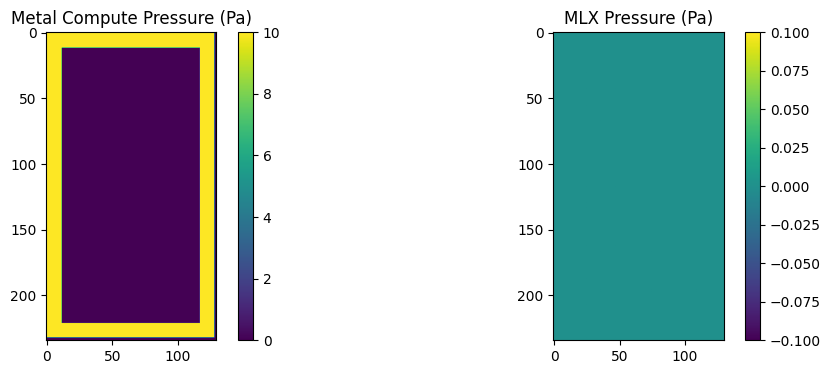

In [11]:
# Save to new name
results_map_mc = last_map_results_mc['Sigma_xy'].T
results_map_mlx = last_map_results_mlx['Sigma_xy'].T
# results_map_mlx = results_map_mc

# Create figure and axis
results_figure = plt.figure(figsize=(12, 4))
results_plot_1,results_plot_2 = results_figure.figure.subplots(1,2)

# Display Metal Compute RMS Pressure map
im1 = results_plot_1.imshow(
    results_map_mc,
    # extent=[xfield.min(), xfield.max(), zfield.max(), zfield.min()],
    # cmap=plt.cm.jet,
    # vmin=BaselineTemperature
)

# Display MLX temperature map
im2 = results_plot_2.imshow(
    results_map_mlx,
    # extent=[xfield.min(), xfield.max(), zfield.max(), zfield.min()],
    # cmap=plt.cm.jet,
    # vmin=BaselineTemperature
)

# Set titles
results_plot_1.set_title('Metal Compute Pressure (Pa)')
results_plot_2.set_title('MLX Pressure (Pa)')

# Add color bars
plt.colorbar(im1, ax=results_plot_1)
plt.colorbar(im2, ax=results_plot_2)

# Show plots
plt.show()

## Compare Data

Data matches? False
Dice Coefficient: 0.745531914893617
Difference Histogram
0.00 to 1.00: 22776
1.00 to 2.00: 0
2.00 to 3.00: 0
3.00 to 4.00: 0
4.00 to 5.00: 0
5.00 to 6.00: 0
6.00 to 7.00: 0
7.00 to 8.00: 0
8.00 to 9.00: 0
9.00 to 10.00: 7774
Mean square error: 25.4468085106383
Normalized root mean square error: 0.5044482977534794


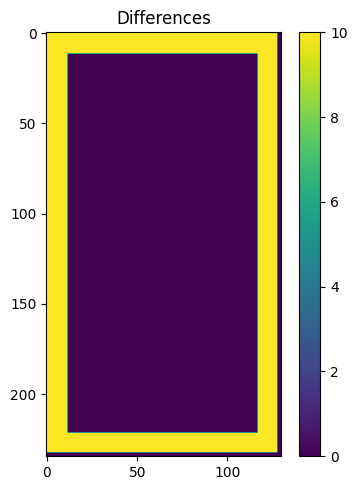

In [12]:

tolerance = 1e-6
data_match = np.all(results_map_mc == results_map_mlx)
print("Data matches?", data_match)

if not data_match:
    # DICE coefficient calculation
    matches = abs(results_map_mlx - results_map_mc) < tolerance
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (results_map_mc.size + results_map_mlx.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(results_map_mlx.T - results_map_mc.T)

    fig, axs = plt.subplots(1, 1, figsize=(4, 5))
    axs.set_title('Differences')
    diff_im1 = axs.imshow(diffs.T)
    plt.colorbar(diff_im1, ax=axs)
    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(results_map_mc,results_map_mlx)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(results_map_mc,results_map_mlx,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")